# Pitchers Standard Types 
The goal is:
* Given files that contain - one per record - each pitch thrown in the Statcase era (i.e., since 2017)
* Built a file that for each pitcher contains the normalized statcast data for each type of pitch that he throws.

# Configure Notebook
### Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import io

import boto3
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac

### HTML/CSS Styling for Markdown

In [2]:
%%html
<style>
.rendered_html tr, .rendered_html th, .rendered_html td {
  text-align: left;
}
# .rendered_html :first-child {
#   text-align: left;
# }
# .rendered_html :last-child {
#   text-align: left;
# }
</style>

# Build Data of Selected Pitch Events
Build a DataFrame with all of the pitch events that meet certain criteria (e.g., regular season, recorded by statcast) will be selected

### List Pitch Event Files
Load in all pitch event files from the selected period (based on the prefix variable).

* All files are available at [event files](https://s3.console.aws.amazon.com/s3/buckets/appleforge-merlin-develop-datalake/savant/?region=us-east-1&tab=overview)
* Files are in bucket name: appleforge-merlin-develop-datalake
* Path names are: savant/&lt;year&gt;-&lt;month&gt;-&lt;day&gt;.csv


In [43]:
bucket_name = 'appleforge-merlin-develop-datalake'
prefix = 'savant/2019'
s3_client = boto3.client('s3')
paginator = s3_client.get_paginator('list_objects_v2')
pages = paginator.paginate(
    Bucket = bucket_name,
    Prefix = prefix
)
s3_objects = [key for page in pages for key in page['Contents']]
files = list(map(lambda o: o.get('Key'), s3_objects))
f"Pitch Event File Count: {len(files)}"

'Pitch Event File Count: 365'

### Build Data Frame of all Pitch Events

| Field | Description |
|:-------|:-------------|
| pitcher | MLB Player Id tied to the play event. |
| pitch_name  | The name of the pitch derived from the Statcast Data. |
| release_speed  |Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.|
| release_pos_x  |Horizontal Release Position of the ball measured in feet from the catcher's perspective.|
| release_pos_z  |Vertical Release Position of the ball measured in feet from the catcher's perspective.|
| game_type  |Type of Game. E = Exhibition, S = Spring Training, R = Regular Season, F = Wild Card, D = Divisional Series, L = League Championship Series, W = World Series|
| p_throws  |Hand pitcher throws with.|
| type  |Short hand of pitch result. B = ball, S = strike, X = in play.|
| pfx_x  |Horizontal movement in feet from the catcher's perspective.|
| pfx_z  |Vertical movement in feet from the catcher's perspective.|
| plate_x  |Horizontal position of the ball when it crosses home plate from the catcher's perspective.|
| plate_z  |Vertical position of the ball when it crosses home plate from the catcher's perspective.|
| vx0  |The velocity of the pitch, in feet per second, in x-dimension, determined at y=50 feet.|
| vy0  |The velocity of the pitch, in feet per second, in y-dimension, determined at y=50 feet.|
| vz0  |The velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet.|
| ax  |The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet.|
| ay  |The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet.|
| az  |The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet.|
| sz_top  |Top of the batter's strike zone set by the operator when the ball is halfway to the plate.|
| sz_bot  |Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate.|
| release_spin_rate  |Spin rate of pitch tracked by Statcast.|
| release_extension  |Release extension of pitch in feet as tracked by Statcast.|

In [44]:
s3_session = boto3.session.Session().resource('s3')

def fetch_df(key: str) -> pd.DataFrame:
    zip_file_object = s3_session.Object(
        bucket_name=bucket_name,
        key=key
    )
    buffer = io.BytesIO(zip_file_object.get()["Body"].read())
    columns = ['pitcher','pitch_name','release_speed','release_pos_x','release_pos_z','game_type','p_throws','type','pfx_x', 
               'pfx_z','plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'release_spin_rate', 
              'release_extension']
    df = pd.read_csv(
        filepath_or_buffer=buffer,
        header=0,
        sep=',',
        quotechar='"',
        usecols=columns,
        dtype={
            'release_speed': np.float64,
            'release_pos_x': np.float64,
            'release_pos_z': np.float64,
            'pitcher': object,
            'game_type': object,
            'p_throws': object,
            'type': object,
            'pfx_x': np.float64,
            'pfx_z': np.float64,
            'plate_x': np.float64,
            'plate_z': np.float64,
            'vx0': np.float64,
            'vy0': np.float64,
            'vz0': np.float64,
            'ax': np.float64,
            'ay': np.float64,
            'az': np.float64,
            'sz_top': np.float64,
            'sz_bot': np.float64,
            'release_spin_rate': np.float64,
            'release_extension': np.float64,
            'pitch_name': object
        }
    )
    return df

list_of_dataframes = list(map(fetch_df, files))
df = pd.concat(list_of_dataframes)
f"Pitch Event Count: {len(df)}"

'Pitch Event Count: 743572'

### Filter to Only Include Regular Season Pitches with Statcast
* Spring Training games are not good measures of pitcher repertoire or velocity.
* Playoff Games are likely to see non-standard usage
* Regular Season games overseas do not have Statcast
* Filter out pitches where pitch type is not identified

In [45]:
regular_season_games_vector = (~df['release_spin_rate'].isna()) & (df['game_type'] == 'R')
unidentified_vector = (df['pitch_name'].isna())
df = df[regular_season_games_vector & ~unidentified_vector]
f"Regular Season Pitch Event Count: {len(df)}"

'Regular Season Pitch Event Count: 715002'

# Build a Data Frame of Mean Pitcher Attributes, per Pitch Type
We want to build a dataframe with one record per pitcher, with the following fields:
* pitcher (as the index)
* p_throws

And then for each of the following pitch types:
* 4-Seam Fastball
* Curveball
* Changeup
* Slider
* Sinker
* Cutter
* 2-Seam Fastball
* Split Finger
* Knuckle Curve

The means of each of the following pitch attributes:
* release_speed
* release_pos_x
* release_pos_z
* pfx_x
* pfx_z
* plate_x
* plate_z
* vx0
* vy0
* vz0
* ax
* ay
* az
* sz_top
* sz_bot
* release_spin_rate
* release_extension

And usage information:
* pitch_count
* pct_usage

In [46]:
attributes_to_use=[
    'release_speed',
    'release_pos_x',
    'release_pos_z',
    'pfx_x',
    'pfx_z',
    'plate_x',
    'plate_z',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'sz_top',
    'sz_bot',
    'release_spin_rate',
    'release_extension'
]
df_pitch_stat_per_pitch = df.groupby(['pitcher','p_throws', 'pitch_name'])[attributes_to_use].mean()#.reset_index()
df_pitch_stat_per_pitch[:20]

release_speed  release_pos_x  release_pos_z  \
pitcher p_throws pitch_name                                                     
282332  L        4-Seam Fastball      88.763636       2.332150       5.940445   
                 Changeup             82.674408       2.393445       5.752897   
                 Cutter               88.337379       2.273298       5.963990   
                 Sinker               89.150607       2.275445       5.922097   
                 Slider               79.214871       2.367873       5.852163   
407845  R        2-Seam Fastball      93.553102      -2.114606       6.044105   
                 4-Seam Fastball      94.378161      -2.024091       6.071957   
                 Changeup             82.965164      -2.338205       6.020931   
                 Slider               86.257143      -2.241171       6.137632   
424144  L        4-Seam Fastball      91.475000       2.020920       5.711447   
                 Sinker               91.772340       2.627970       5.236904   
                 Slider               78.477814       2.465632       5.230219   
425772  R        Curveball            75.474074       0.047485       6.831141   
425794  R        4-Seam Fastball      89.601323      -1.454041       6.066654   
                 Changeup             83.914035      -1.681225       5.973912   
                 Curveball            74.876878      -1.512757       6.090847   
                 Cutter               84.873829      -1.526068       6.067578   
                 Sinker               89.982235      -1.522320       5.920186   
425844  R        2-Seam Fastball      90.410976      -1.458332       6.253954   
                 4-Seam Fastball      89.874921      -1.258342       6.363893   

                                     pfx_x     pfx_z   plate_x   plate_z  \
pitcher p_throws pitch_name                                                
282332  L        4-Seam Fastball  0.532559  0.904191 -0.051023  2.993818   
                 Changeup         0.735077  0.646152  0.603449  1.946955   
                 Cutter           0.008638  0.872177 -0.391837  3.011530   
                 Sinker           1.108062  0.702111  0.520808  2.276210   
                 Slider          -0.905879  0.102892  0.150849  1.886370   
407845  R        2-Seam Fastball -1.127106  1.048140 -0.254534  2.373509   
                 4-Seam Fastball -0.453421  1.440849  0.342931  2.413675   
                 Changeup        -1.259207  0.643834 -0.504362  1.788918   
                 Slider           0.190239  0.616268  0.630725  1.660314   
424144  L        4-Seam Fastball  0.963758  1.252488  0.046544  2.876241   
                 Sinker           1.518448  0.572434  0.054111  2.388609   
                 Slider          -0.753534 -0.063493 -0.337124  1.888275   
425772  R        Curveball       -0.159637  1.718370 -0.212033  2.961078   
425794  R        4-Seam Fastball -0.257106  1.134674 -0.302921  2.564647   
                 Changeup        -1.203437  0.660389 -0.982886  1.959649   
                 Curveball        1.530294 -1.011142  0.031276  1.945421   
                 Cutter           0.457839  0.469250  0.631937  2.280974   
                 Sinker          -1.076331  0.795670  0.194256  2.410520   
425844  R        2-Seam Fastball -1.108571  1.002177 -0.465601  2.141180   
                 4-Seam Fastball -0.165044  1.376091 -0.041422  2.364353   

                                       vx0         vy0       vz0         ax  \
pitcher p_throws pitch_name                                                   
282332  L        4-Seam Fastball -7.039295 -129.273514 -3.184727   7.442205   
                 Changeup        -5.653336 -120.457873 -3.604891   8.409503   
                 Cutter          -6.563730 -128.646214 -3.041906   1.317336   
                 Sinker          -6.770979 -129.770530 -4.525984  14.147763   
                 Slider          -3.166742 -115.354029 -2.095743  -7.488855   
407845  R        2-Seam F

### Build percentage usage information

In [47]:
df_per_pitch_count = df.copy().groupby(['pitcher','p_throws', 'pitch_name'])['release_speed'].count().to_frame()
df_per_pitch_count.set_axis(['pitch_count'], axis=1, inplace=True)
df_per_pitch_count.reset_index(level=[2], inplace=True)
df_total_count = df.groupby(['pitcher','p_throws'])['release_speed'].count().to_frame().copy()
df_total_count.set_axis(['total_count'], axis=1, inplace=True)

df_pct_usage = pd.merge(df_per_pitch_count, df_total_count, how='left', on=['pitcher','p_throws'])
df_pct_usage['pct_usage']=df_pct_usage['pitch_count']/df_pct_usage['total_count']
df_pct_usage.set_index(['pitch_name'], append=True, inplace=True)
df_pct_usage[:10]

pitch_count  total_count  pct_usage
pitcher p_throws pitch_name                                          
282332  L        4-Seam Fastball           22         1669   0.013182
                 Changeup                 211         1669   0.126423
                 Cutter                   725         1669   0.434392
                 Sinker                   247         1669   0.147993
                 Slider                   464         1669   0.278011
407845  R        2-Seam Fastball          403          849   0.474676
                 4-Seam Fastball          174          849   0.204947
                 Changeup                 244          849   0.287397
                 Slider                    28          849   0.032980
424144  L        4-Seam Fastball           96          642   0.149533

### Join Percentage Usage to Table

In [48]:
# df_pitch_stat_per_pitch = pd.merge(df_pitch_stat_per_pitch, df_pct_usage[['pitch_count', 'pct_usage']], on=['pitcher', 'p_throws', 'pitch_name'])
df_pitch_stat_per_pitch = pd.merge(df_pitch_stat_per_pitch, df_pct_usage[['pct_usage']], on=['pitcher', 'p_throws', 'pitch_name'])
df_pitch_stat_per_pitch[:10]

release_speed  release_pos_x  release_pos_z  \
pitcher p_throws pitch_name                                                     
282332  L        4-Seam Fastball      88.763636       2.332150       5.940445   
                 Changeup             82.674408       2.393445       5.752897   
                 Cutter               88.337379       2.273298       5.963990   
                 Sinker               89.150607       2.275445       5.922097   
                 Slider               79.214871       2.367873       5.852163   
407845  R        2-Seam Fastball      93.553102      -2.114606       6.044105   
                 4-Seam Fastball      94.378161      -2.024091       6.071957   
                 Changeup             82.965164      -2.338205       6.020931   
                 Slider               86.257143      -2.241171       6.137632   
424144  L        4-Seam Fastball      91.475000       2.020920       5.711447   

                                     pfx_x     pfx_z   plate_x   plate_z  \
pitcher p_throws pitch_name                                                
282332  L        4-Seam Fastball  0.532559  0.904191 -0.051023  2.993818   
                 Changeup         0.735077  0.646152  0.603449  1.946955   
                 Cutter           0.008638  0.872177 -0.391837  3.011530   
                 Sinker           1.108062  0.702111  0.520808  2.276210   
                 Slider          -0.905879  0.102892  0.150849  1.886370   
407845  R        2-Seam Fastball -1.127106  1.048140 -0.254534  2.373509   
                 4-Seam Fastball -0.453421  1.440849  0.342931  2.413675   
                 Changeup        -1.259207  0.643834 -0.504362  1.788918   
                 Slider           0.190239  0.616268  0.630725  1.660314   
424144  L        4-Seam Fastball  0.963758  1.252488  0.046544  2.876241   

                                       vx0         vy0       vz0         ax  \
pitcher p_throws pitch_name                                                   
282332  L        4-Seam Fastball -7.039295 -129.273514 -3.184727   7.442205   
                 Changeup        -5.653336 -120.457873 -3.604891   8.409503   
                 Cutter          -6.563730 -128.646214 -3.041906   1.317336   
                 Sinker          -6.770979 -129.770530 -4.525984  14.147763   
                 Slider          -3.166742 -115.354029 -2.095743  -7.488855   
407845  R        2-Seam Fastball  7.189901 -135.936405 -5.979580 -15.318015   
                 4-Seam Fastball  7.082610 -137.075076 -6.913261  -7.142279   
                 Changeup         6.559711 -120.548462 -4.419523 -13.347538   
                 Slider           6.363714 -125.342475 -5.626868   0.811093   
424144  L        4-Seam Fastball -6.975403 -132.987164 -3.929452  12.754768   

                                         ay         az    sz_top    sz_bot  \
pitcher p_throws pitch_name                                                  
282332  L        4-Seam Fastball  24.019082 -21.347741  3.377491  1.609018   
                 Changeup         21.193987 -25.188488  3.408630  1.619749   
                 Cutter           23.546948 -21.893517  3.392530  1.617237   
                 Sinker           25.592859 -23.325592  3.372470  1.599940   
                 Slider           21.284541 -31.060740  3.360388  1.600627   
407845  R        2-Seam Fastball  27.906750 -18.272031  3.350316  1.586062   
                 4-Seam Fastball  29.086636 -12.967420  3.357322  1.593544   
                 Changeup         22.624225 -25.366894  3.331402  1.580679   
                 Slider           22.777471 -24.927875  3.324207  1.586779   
424144  L        4-Seam Fastball  26.809645 -16.878071  3.372581  1.605428   

                                  release_spin_rate  release_extension  \
pitcher p_throws pitch_name                                              
282332  L        4-Seam Fastball        2097.954545           6.837545   
                 Changeup               

### Flatten Table

In [49]:
pitch_conversion_map={
    "4-Seam Fastball": "4f",
    "2-Seam Fastball": "2f",
    "Changeup": "ch",
    "Curveball": "cu",
    "Sinker": "sk",
    "Slider": "sl",
    "Split Finger": "sf",
    "Cutter": "ct",
    "Eephus": "ee",
    "Knuckle Ball": "kn",
    "Forkball": "fk",
    "Knuckle Curve": "kc"
}

# flat_map_attrs = attributes_to_use + ['pitch_count', 'pct_usage']
flat_map_attrs = attributes_to_use + ['pct_usage']
df_flat_pitch_info = df_pitch_stat_per_pitch.copy()
df_flat_pitch_info.reset_index(level=[2], inplace=True)
df_flat_pitch_info['pitch_name']=df_flat_pitch_info['pitch_name'].map(pitch_conversion_map)
df_flat_pitch_info.set_index(['pitch_name'], append=True, inplace=True)

df_flat_pitch_info = df_flat_pitch_info.unstack()
new_column_names = list(map(lambda tuple: '_'.join(reversed(tuple)), df_flat_pitch_info.columns.to_flat_index()))
df_flat_pitch_info.columns = new_column_names
df_flat_pitch_info.sort_index(axis=1, inplace=True)
df_flat_pitch_info.reset_index(level=[1], inplace=True)

for pitch_prefix in pitch_conversion_map.values():
    df_flat_pitch_info[pitch_prefix+'_pct_usage'].fillna(0, inplace=True)
    
df_flat_pitch_info.iloc[:10,range(20)]

,p_throws,2f_ax,2f_ay,2f_az,2f_pct_usage,2f_pfx_x,2f_pfx_z,2f_plate_x,2f_plate_z,2f_release_extension,...,2f_sz_top,2f_vx0,2f_vy0,2f_vz0,4f_ax,4f_ay,4f_az,4f_pct_usage,4f_pfx_x,4f_pfx_z
pitcher,,,,,,,,,,,,,,,,,,,,,
282332,L,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.442205,24.019082,-21.347741,0.013182,0.532559,0.904191
407845,R,-15.318015,27.906750,-18.272031,0.474676,-1.127106,1.048140,-0.254534,2.373509,5.992494,...,3.350316,7.189901,-135.936405,-5.979580,-7.142279,29.086636,-12.967420,0.204947,-0.453421,1.440849
424144,L,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.754768,26.809645,-16.878071,0.149533,0.963758,1.252488
425772,R,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
425794,R,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-3.619308,24.967593,-18.275769,0.136118,-0.257106,1.134674
425844,R,-13.633415,26.602776,-19.646351,0.053542,-1.108571,1.002177,-0.465601,2.141180,5.876921,...,3.370925,4.752309,-131.424730,-6.364944,-2.528309,25.531548,-15.447778,0.415279,-0.165044,1.376091
429719,R,-14.745026,28.300096,-19.150133,0.140337,-1.101055,0.958201,-0.804854,2.019749,6.156885,...,3.372361,5.170833,-136.254133,-6.428654,-6.935164,27.543353,-17.803509,0.234663,-0.475387,1.086876
429722,R,-9.002546,26.288269,-18.734862,0.109244,-0.726077,1.107792,-0.108577,2.677531,5.865308,...,3.418481,3.780762,-131.042931,-5.380638,-5.310835,26.472143,-17.673576,0.432773,-0.400217,1.198811
430935,L,14.839308,25.991438,-20.982364,0.120769,1.122967,0.864292,0.290792,2.124836,6.232785,...,3.329565,-8.194710,-132.377754,-6.197553,9.212074,26.894876,-15.788077,0.354785,0.653355,1.307032


# Some Visualizations

## Pitch Type Movement in dt_flat_pitch_info
Each point represents the average of all pfx_x and pfx_z values for a single pitch type thrown a pitcher. Because pitchers throw one or more pitch type, a pitcher may be represented by one point, or by five or more.

These plots just provide visualizations that:
* When pitch types are plotted by their X and Z movement (in feet) they group
* Lefties and Righties are roughly mirror images of each other.

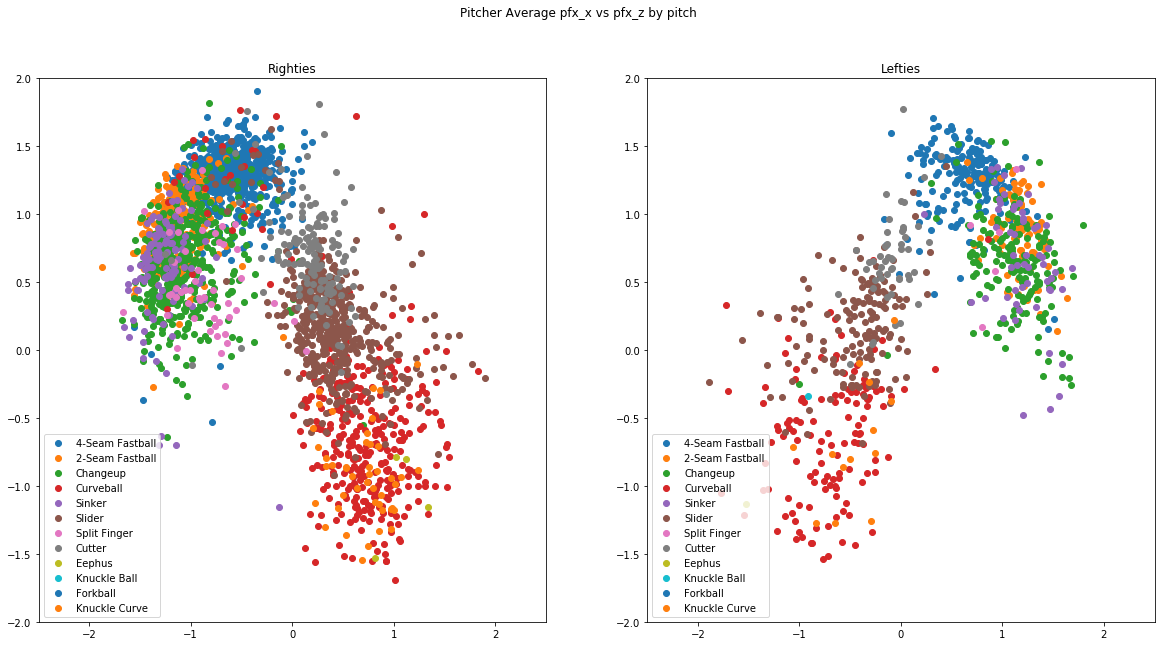

<Figure size 432x288 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Pitcher Average pfx_x vs pfx_z by pitch')
fig = plt.figure()

# make pane
def _make_pane(ax, p_throws_value, title):
    df_pane = df_flat_pitch_info[df_flat_pitch_info['p_throws']==p_throws_value]
    for idx, prefix in enumerate(pitch_conversion_map.values()):
        ax.scatter(
            df_pane[prefix+'_pfx_x'], 
            df_pane[prefix+'_pfx_z'], 
            label=list(pitch_conversion_map.keys())[idx]
        )
    ax.set_title(title)
    ax.legend(loc='lower left')
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2, 2])
    
_make_pane(ax1, 'R', 'Righties')
_make_pane(ax2, 'L', 'Lefties')
plt.show()

## Velocity versus Usage

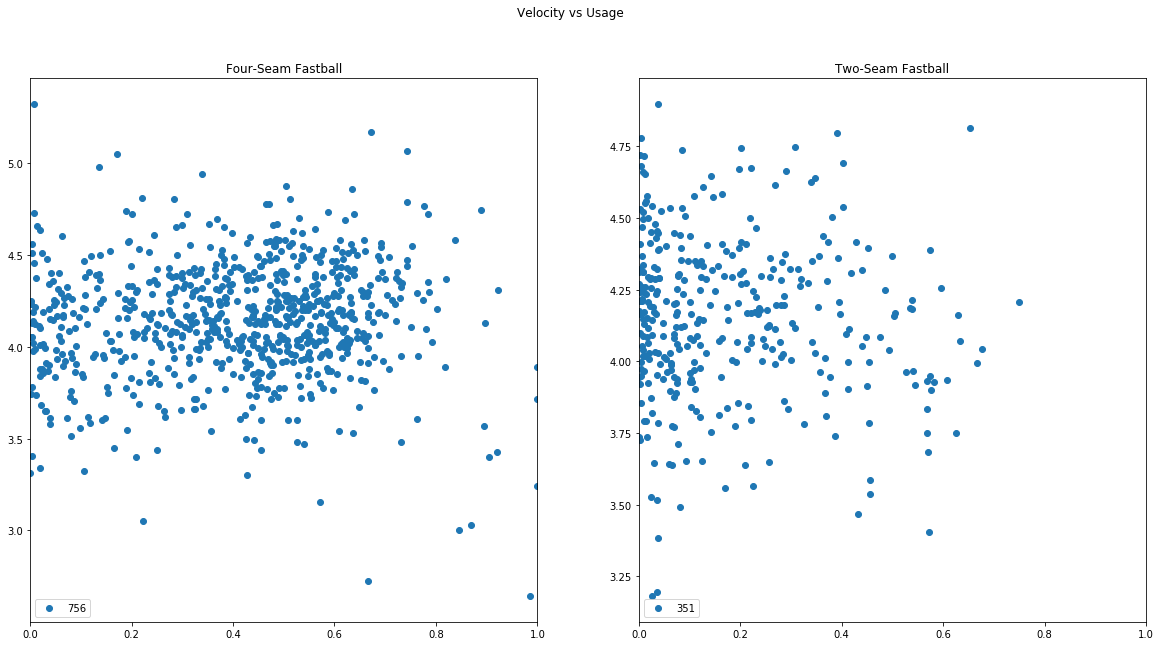

<Figure size 432x288 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Velocity vs Usage')
fig = plt.figure()

# make pane
def _make_pane(ax, pitch_type_prefix, title):
    ax.scatter(
        df_flat_pitch_info[pitch_type_prefix+'_pct_usage'], 
        abs(df_flat_pitch_info[pitch_type_prefix+'_vy0'])/1.467, 
        label=len(df_flat_pitch_info[df_flat_pitch_info[pitch_type_prefix+'_pct_usage']>0])
    )
    ax.set_title(title)
    ax.legend(loc='lower left')
    ax.set_xlim([0, 1])
    
_make_pane(ax1, '4f', 'Four-Seam Fastball')
_make_pane(ax2, '2f', 'Two-Seam Fastball')
plt.show()


# Normalization and Standardization
As follows:


In [62]:
df_rescaled_pitch_info = df_flat_pitch_info.copy()

def standardize_field(df, field_to_standardize):
    mean = df[field_to_standardize].mean(axis=0)
    std = df[field_to_standardize].std(axis=0)
    df[field_to_standardize] = (df[field_to_standardize]-mean)/std
    
def normalize_field(df, field_to_normalize):
    minval = df[field_to_normalize].min(axis=0)
    maxval = df[field_to_normalize].max(axis=0)
    df[field_to_normalize] = (df[field_to_normalize]-minval)/(maxval-minval)

pitch_attributes_to_standardize = [
    'release_speed',
    'release_pos_x',
    'release_pos_z',
    'pfx_x',
    'pfx_z',
    'plate_x',
    'plate_z',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    'sz_top',
    'sz_bot',
    'release_spin_rate',
    'release_extension'
]

pitch_attributes_to_normalize = [
    'pct_usage'
]

columns_to_standardize = list(filter(lambda column_name: column_name[3:] in pitch_attributes_to_standardize, df_rescaled_pitch_info.columns))
columns_to_normalize = list(filter(lambda column_name: column_name[3:] in pitch_attributes_to_normalize, df_rescaled_pitch_info.columns))
list(map(lambda column_name: standardize_field(df_rescaled_pitch_info, column_name), columns_to_standardize))
list(map(lambda column_name: normalize_field(df_rescaled_pitch_info, column_name), columns_to_normalize))
df_rescaled_pitch_info.describe()

,2f_ax,2f_ay,2f_az,2f_pct_usage,2f_pfx_x,2f_pfx_z,2f_plate_x,2f_plate_z,2f_release_extension,2f_release_pos_x,...,sl_release_extension,sl_release_pos_x,sl_release_pos_z,sl_release_speed,sl_release_spin_rate,sl_sz_bot,sl_sz_top,sl_vx0,sl_vy0,sl_vz0
count,3.510000e+02,3.510000e+02,3.510000e+02,830.000000,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,3.510000e+02,...,6.150000e+02,6.150000e+02,6.150000e+02,6.150000e+02,6.150000e+02,6.150000e+02,6.150000e+02,6.150000e+02,6.150000e+02,6.150000e+02
mean,-2.407065e-16,-1.292097e-15,-4.515540e-15,0.101683,3.732374e-17,1.448034e-15,-2.365945e-16,2.467795e-15,3.634320e-15,2.995388e-16,...,1.663710e-15,-1.451414e-16,-1.237210e-15,-1.412204e-14,4.904478e-15,3.069992e-15,-4.834814e-14,-2.350423e-16,2.009955e-15,5.000517e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,0.192076,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.254903e+00,-5.259920e+00,-4.318390e+00,0.000000,-1.254063e+00,-4.587505e+00,-3.712563e+00,-4.761365e+00,-3.444183e+00,-1.453906e+00,...,-3.816871e+00,-2.078393e+00,-7.737255e+00,-7.878803e+00,-4.705402e+00,-6.633944e+00,-7.087466e+00,-2.584539e+00,-2.221391e+00,-2.868824e+00
25%,-6.606724e-01,-5.885088e-01,-6.818167e-01,0.000000,-6.587290e-01,-6.536657e-01,-6.609000e-01,-5.132586e-01,-5.958885e-01,-6.569986e-01,...,-6.457735e-01,-6.827021e-01,-4.689018e-01,-4.304528e-01,-5.680838e-01,-3.391919e-01,-4.211584e-01,-4.896648e-01,-6.320932e-01,-6.329724e-01
50%,-5.022040e-01,-1.518246e-02,5.582217e-02,0.000000,-5.091856e-01,7.233543e-02,-1.040908e-01,1.465171e-03,5.013719e-02,-3.825327e-01,...,-4.417682e-02,-4.122334e-01,1.059336e-01,1.026844e-01,-3.246931e-02,6.008126e-02,2.436256e-02,3.546451e-01,-1.073305e-01,-4.686597e-02
75%,6.784210e-01,6.367385e-01,7.692587e-01,0.108521,6.818494e-01,7.595312e-01,5.644856e-01,5.421363e-01,6.074803e-01,6.178869e-01,...,6.506722e-01,4.569475e-01,6.197562e-01,6.305354e-01,5.489975e-01,4.301760e-01,3.742670e-01,7.246888e-01,4.207579e-01,5.046594e-01
max,2.143318e+00,3.703675e+00,2.101626e+00,1.000000,2.139596e+00,2.065287e+00,4.806255e+00,3.452140e+00,2.655701e+00,2.228879e+00,...,3.210598e+00,2.799978e+00,2.079095e+00,2.190743e+00,3.379572e+00,6.188519e+00,5.852005e+00,2.023950e+00,7.876003e+00,5.548234e+00


In [63]:
df_rescaled_pitch_info.iloc[:10,range(20)]

,p_throws,2f_ax,2f_ay,2f_az,2f_pct_usage,2f_pfx_x,2f_pfx_z,2f_plate_x,2f_plate_z,2f_release_extension,2f_release_pos_x,2f_release_pos_z,2f_release_speed,2f_release_spin_rate,2f_sz_bot,2f_sz_top,2f_vx0,2f_vy0,2f_vz0,4f_ax
pitcher,,,,,,,,,,,,,,,,,,,,
282332,L,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.352296
407845,R,-0.545069,-0.007018,0.675023,0.632901,-0.529787,0.626222,-0.131740,0.097922,-0.231211,-0.653028,0.473424,0.266002,-0.961867,-0.443407,-0.374180,0.667850,-0.254029,-0.569486,-0.309558
424144,L,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.957645
425772,R,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425794,R,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.091873
425844,R,-0.422223,-0.632582,0.263444,0.071390,-0.511866,0.444389,-0.557522,-0.513210,-0.511994,-0.302382,0.962265,-0.797717,0.322804,-0.064249,-0.075216,0.272078,0.792688,-0.811780,0.216189
429719,R,-0.503285,0.181685,0.412050,0.187117,-0.504599,0.270413,-1.241893,-0.832632,0.168175,-0.527747,0.173925,0.315547,-0.525451,0.767188,-0.054382,0.340030,-0.327743,-0.851837,-0.285958
429722,R,-0.084525,-0.783462,0.536415,0.145658,-0.142044,0.862211,0.162699,0.897642,-0.540207,-0.074880,1.119819,-0.902993,-1.057198,-0.251112,0.614662,0.114335,0.881266,-0.192906,-0.100871
430935,L,1.654101,-0.925863,-0.136663,0.161025,1.645740,-0.101097,0.968342,-0.556205,0.352573,1.869637,0.841727,-0.558367,-0.997691,-0.053925,-0.675213,-1.830028,0.571584,-0.706534,1.553966


# Output
Output both:
* df_flat_pitch_info, which has raw values
* df_rescaled, for which most values are standardized, pct_usage is normalized.

In [65]:
import s3fs

def _write_out_df(df, key):
    bytes_to_write = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem()
    with fs.open('s3://{bucket}/{key}'.format(
            bucket=bucket_name,
            key=key
        ), 'wb') as f:
        f.write(bytes_to_write)
        
_write_out_df(df_flat_pitch_info, 'pitchtype/df_flat_pitch_info.csv')
_write_out_df(df_rescaled_pitch_info, 'pitchtype/df_rescaled_pitch_info.csv')